# The Curious Case of Convolution and FFT

_Convolution in the spatial domain equals multiplication in the Fourier domain_.

By the end of this post, we hope to aquaint the reader with the reason and implication for this statement. We will start by considering the continuous domain, where this is easiest to show.

## The Continuous Time Variant

Lets assume a signal $x(t)$ is convolved by the transfer function $h(t)$ to produce output signal $y(t)$. Symbolically,

$$y(t) = x(t) * h(t)$$

Now, the Fourier transform guarantees us for any Lesbegue integrable function (an intuitive understanding is a signal of finite power), we have a representation via an integral of complex exponentials. Check out this excellant [link](https://www.youtube.com/watch?v=spUNpyF58BY) , courtesy of _3Blue1Brown_ if you would like a more grounded understanding of the Fourier transform before proceeding with the rest of this post.

Essentially:

\begin{align}
h(t) &= \int_{-\infty}^{\infty} H(f) \exp(j2\pi ft)df \quad \text{Inverse Fourier Transform} \\
H(f) &= \int_{-\infty}^{\infty} h(t) \exp(-j2\pi ft)df \quad \text{Fourier Transform}
\end{align}

Formally we denote, $H(f) = \mathcal{F}[h(t)], h(t) = \mathcal{F}^{-1}[H(f)]$.

Plug this in for $h(t)$, we get: (we are integrating over the real axis, and omit the limits for brevity)

\begin{align}
y(t) &= \int x(\tau) h(t - \tau) d\tau \quad \text{By defn of convolution} \\
&= \int x(\tau) \int H(f) \exp(j2\pi f(t-\tau)) df d\tau \quad \text{Plug in the inverse fourier transform} \\
&= \int [\int x(\tau) \exp(-j2\pi f\tau) d\tau] H(f) \exp(j2\pi ft) df \quad \text{A bit of rearrangement} \\
&= \int X(f) H(f) \exp(j2\pi ft) df \quad \text{A bit of rearrangement} \\
&=  \mathcal{F}^{-1} (H(f)X(f))
\end{align}

And that's it. You've successfully shown the above statement. Now before we complicate matters more, let's visit an example.

In order to deal with a continuous signal, we sample it discretely at a sampling frequency of $f_s$. Let's implement the definition of convolution, ie..., flip, shift and integrate.

In [11]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
%matplotlib inline 

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

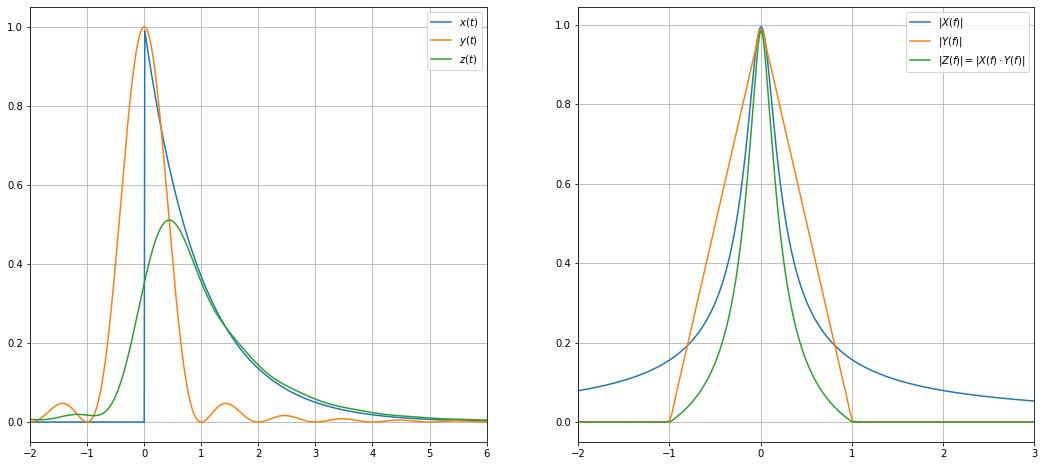

In [21]:
Fs = 100    # sampling frequency
T = 10      # time duration we want to look at
t = np.arange(-T, T, 1/Fs)  # the corresponding time samples

# define our two functions
x = lambda t: np.exp(-abs(t)) * (t>=0)
y = lambda t: np.sinc(t)**2

# the resulting time range, when convolving both signals
t_conv = np.arange(-2*T, 2*T, 1/Fs)[:-1]

plt.figure(figsize=(18,8))
plt.subplot(121) 
plt.plot(t, x(t))
plt.plot(t, y(t))
z = np.convolve(x(t), y(t))/Fs
plt.plot(t_conv, z)
plt.xlim(-2,6)
plt.grid()
plt.legend(("$x(t)$","$y(t)$","$z(t)$"))

plt.subplot(122)
# function to calculate the spectrum of the input signal
spec = lambda x: abs(np.fft.fftshift(np.fft.fft(x, 4*len(t))))/Fs
X = spec(x(t))
Y = spec(y(t))
Z = spec(z)
f = np.linspace(-Fs/2, Fs/2, len(X))
plt.plot(f, X)
plt.plot(f, Y)
plt.plot(f, Z)
plt.xlim(-2,3)
plt.grid()
plt.legend(("$|X(f)|$","$|Y(f)|$","$|Z(f)|=|X(f)\\cdot Y(f)|$"))
plt.show()

In the above example, we have convolved an exponential impulse $x(t)$ with a sinc-squared function $y(t)$. 

The result of the convolution $z(t)$ is shown in the red curve. On the left-hand side, we can look at the time domain. In the diagram on the right side, the spectrum of all signals is shown. We see that the spectrum of the exponential impulse is very wide in frequency domain (this is clear, since we have the abrupt jump at $t=0$ in the time domain). On the other side, the sinc-squared function corresponds to a triangle in the frequency domain with $|Y(f)|=0,|f|≥1$. Eventually, the red curve is the product of the green and blue curves: For $f=0$, it starts at $|Z(f)|_{f=0}=1$ and decays with increasing $f$. At $f=1$, where the green triangle has decayed to zero, also the red curve decayed to zero.

Let us now look at another example: We convolve a Gaussian bell function with an ideal lowpass of different cutoff frequencies. Since the ideal lowpass has an infinite time domain response which decays rather slow, we add a Hanning window to the function such that the resulting spectra will look more smooth.

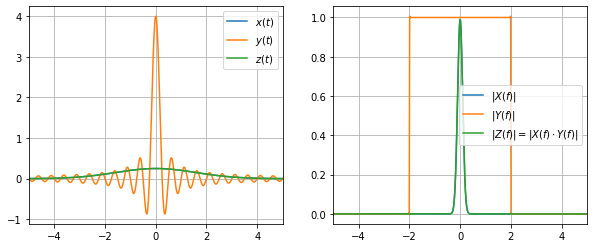

In [26]:
gauss = lambda t: np.exp(-0.2*t*t) / 4 # The Gaussian Bell function
def lowpass(fc): # return impulse response of the ideal lowpass with cutoff fc
    return lambda t: 2*fc * np.sinc(2*fc*t)
    
def showConvolution(x, y):
    Fs = 100                    # signal sampling frequency
    T = 100                     # time duration for the impulse response to decay
    t = np.arange(-T, T, 1/Fs)  # the time samples
    # the time samples of the signal after convolution
    t_convolved = np.arange(-2*T, 2*T, 1/Fs)[:-1]  
    
    # Get the samples of the signals. Multiply with Hanning window 
    # to mitigate ringing/spectral leakage in the frequency domain
    x_samples = x(t) * np.hanning(len(t))
    y_samples = y(t) * np.hanning(len(t))
    z_samples = np.convolve(x_samples, y_samples) / Fs

    spec = lambda x: np.fft.fftshift(np.fft.fft(x, 16*len(t))) / Fs
    X_samples = spec(x_samples)
    Y_samples = spec(y_samples)
    Z_samples = spec(z_samples)
    f = np.linspace(-Fs/2, Fs/2, len(X_samples), endpoint=False)    
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.xlim(-5,5)
    plt.plot(t, x_samples)
    plt.plot(t, y_samples)
    plt.plot(t_convolved, z_samples)
    plt.legend(("$x(t)$","$y(t)$","$z(t)$"))
    plt.grid()

    plt.subplot(122)
    plt.plot(f, abs(X_samples))
    plt.plot(f, abs(Y_samples))
    plt.plot(f, abs(Z_samples))
    plt.xlim(-5,5)
    plt.legend(("$|X(f)|$","$|Y(f)|$","$|Z(f)|=|X(f)\\cdot Y(f)|$"))
    plt.grid()
    
    plt.show()
    

    showConvolution(gauss, lowpass(2))

## Exercise 1

Try playing about with the cutoff frequency and see what happens. How does the signal width in the time domain increase as the cutoff varies. You should observe the familiar tradeoff between spatial and frequency domain.

Remove the Hanning Window and observe what happens. Why do you notice such distortions (called ringing)?

## Let's multiply instead ...

Time for us to put the earlier derivation to use. We convolve by multiplying in the Fourier domain and taking its inverse transform. In symbols:

$$y(t) = \mathcal{F}^{-1} [\mathcal{F}(x) \cdot \mathcal{F}(h)](t)$$

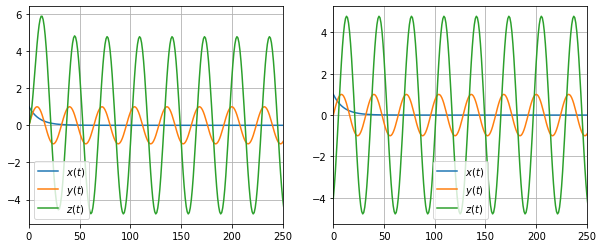

In [30]:
N = 512
n = np.arange(N)

x_samples = np.exp(-0.1*n)
y_samples = np.sin(2*np.pi*n/32)
z_samples = np.convolve(x_samples, y_samples)
# Application of the convolution theorem:
z2_samples = np.fft.ifft(np.fft.fft(x_samples) * np.fft.fft(y_samples)).real

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(x_samples)
plt.plot(y_samples)
plt.plot(z_samples)
plt.xlim(0,250)
plt.legend(("$x(t)$","$y(t)$","$z(t)$"))
plt.grid()

plt.subplot(122)
plt.plot(x_samples)
plt.plot(y_samples)
plt.plot(z2_samples)
plt.xlim(0,250)
plt.legend(("$x(t)$","$y(t)$","$z(t)$"))
plt.grid()

plt.show()

## The need for FFT Shift

Okay, so what went wrong there? Why is our output signal differing in the initial region?

This is because of the discretisation and deadling with the nature of the Discrete Fourier Transform (DFT). Let's dig into the DFT to understand this better.

### The DFT

Discrete convolution is represented by:

$$y[n] = \sum_{m=-\infty}^{\infty} x[m]h[n-m]$$

We have the fourier transform of a discrete signal given by:

\begin{align}
h[n] &= \int_{-\infty}^{\infty} H(f) \exp(j2\pi fn)df \quad \text{Inverse Fourier Transform} \\
H(f) &= \sum_{n=-\infty}^{\infty} h[n] \exp(-j2\pi fn) \quad \text{Fourier Transform}
\end{align}

In this case too one can verify that convolution in the spatial domain is multiplication in the fourier domain (treat this as **exercise 2**!). Notice the subtlity here: the Fourier domain is continous, but the spatial is discrete. Clearly, this can represent convolution in the spatial domain. But we still need to handle the Fourier aspect.

Now, let's sample $H(f)$. Let $\tilde{H}[k] = H(f=k/N)$. This sequence has a period of $N$, since the fourier transform is periodic in $f$ with period 1.

Define the sequence,

\begin{align}
\tilde{h}[n] &= 1/N \sum_{k=0}^{N-1} \tilde{H}[k] \exp(j2\pi kn)\\
&= 1/N \sum_{k=0}^{N-1} [\sum_{m=-\infty}^\infty h[m] \exp(-j2\pi k/N * m ]\exp(j2\pi kn/N) \\
&= \sum_{m=-\infty}^\infty h[m] [1/N \sum_{k=0}^{N-1}  \exp(j2\pi k(n-m)/N)] \\
&= \sum_{m=-\infty}^\infty h[m] p(n-m) \\
\end{align}

The particular reader might recognise this as a Discrete Fourier Series (DFS).

One can show that $p(n-m) = \sum_{r=\-infty}^{\infty}\delta [n-m-rN]$ (**exercise 3**).

Hence, $\tilde{h}[n] = \sum_{m=-\infty}^\infty h[n - mN]$, ie..., copies of $h$ shifted and added together.

Now assume that $h[n]$ is non-zero only between $0,...,c$, with $c<N$. Then, we can extract $h[n]$ by just taking one period of $\tilde{h}[n]$. In summary, **if the signal is finite, we donot need the entire continuous version of the Fourier transform, just a finite set.**

For notation, call

$\tilde{h}[n] = h[n modulo N], \tilde{H}[n] = H(k modulo N)$.

Then we have,

\begin{align}
\tilde{h}[n] &= 1/N \sum_{k=0}^{N-1} H[k] \exp(j2\pi kn/N) \quad \text{Inverse Discrete Fourier Transform} \\
\tilde{H}[k] &= \sum_{n=0}^{N-1} h[n] \exp(-j2\pi kn/N) \quad \text{Discrete Fourier Transform}
\end{align}

Convolving two such repeated signals is called **cirucular convolution**. This is what causes the initial distortion. If the signal cannot be contained within $N$, then the next cycle's sum slips into the result. As **exercise 4**, show that the DFT equals circular convolution.

So what's the easy solution? Just pad zeros!

What's a safe amount (infact the minimum) to pad? $L_1 + L_2 -1$, where $L_1$ is the length of the first signal and $L_2$ the second. 

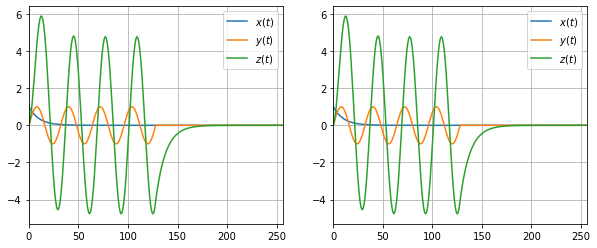

In [32]:
N = 128
n = np.arange(N)
Z = np.zeros(N)

x_samples = np.hstack([np.exp(-0.1*n), Z])
y_samples = np.hstack([np.sin(2*np.pi*n/32), Z])
z_samples = np.convolve(x_samples, y_samples)
z2_samples = np.fft.ifft(np.fft.fft(x_samples) * np.fft.fft(y_samples)).real

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(x_samples)
plt.plot(y_samples)
plt.plot(z_samples)
plt.legend(("$x(t)$","$y(t)$","$z(t)$"))
plt.grid()
plt.xlim((0,2*N))

plt.subplot(122)
plt.plot(x_samples)
plt.plot(y_samples)
plt.plot(z2_samples)
plt.legend(("$x(t)$","$y(t)$","$z(t)$"))
plt.grid()
plt.xlim((0,2*N))

plt.show()

## FFT: What's sacred about $2^n$?

Now, what is with the act of choosing $N = 2^n$? As we shall see, that is a special case, where we can use an optimal implementation of the DFT called the Fast Fourier Transform. 

Let's first recast the DFT as a matrix multiplication. Notice that, 

$$H[k] = 1/N \begin{bmatrix} 1 & 1 & 1 & ... & 1 \\ 1 & \omega & \omega^2 & ... & \omega^{N -1} \\   . & . & . & ... & . \\ . & . & . & ... & . \\  . & . & . & ... & . \\1 & \omega^{N-1} & \omega^{2(N-1)} & ... & \omega^{(N-1)(N -1)} \end{bmatrix} h[n]$$

where, $\omega = \exp(j2\pi/N)$.

One can implement this naively with cost $O(N^2)$. FFT uses divide and conquer to get this down to $O(N\log N)$, which is much more feasible in practice. Infact FFT refers to any fourier transform algorithm with complexity $O(N\log N)$. The following figure illustrates the DFT matrix (_credits: Wikipedia, DFT Matrix_).

![dft](dft_matrix.png)

## The Cooley Tuckey Algorithm

We now describe one of the earliest and simplest FFT algorithms, the cooley-tuckey algorithm. It re-expresses the discrete Fourier transform (DFT) of an arbitrary composite size $N = N_1N_2$ in terms of $N_1$ smaller DFTs of sizes $N_2$, recursively, to reduce the computation time to $O(N \log N)$ for highly composite $N$ (smooth numbers).

Assume $N=2^v, \quad v \in \mathcal{N}$, ie..., a power of $2$.

We have:

\begin{align}
X_k &= \sum_{n=0}^{N-1}x_n \exp(-2j\pi nk/N)\\
&= \sum_{m=0}^{N/2 - 1} x_{2m} \exp(-2j\pi 2mk/N) + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \exp(-2j\pi (2m+1)k/N) \quad \text{Split into odd and even} \\
&= E_k + \exp(-2j\pi k/N)O_k \quad \text{Split into 2 DFTs}
\end{align}

One can also note that, $X_{k+N/2} = E_k - \exp(-2j\pi k/N)O_k$. Hence, we have split a DFT into two smaller ones.

To trace it, you would do a size-2 DFT (called butterfly), then use E_2 and O_2 to get X_4. Hence, gives E_4, O_4.

We won't write out a pseudo code here, but certainly do encourage you to try.

## References

1. Oppenheim and Schafer, Discerete Time Signal Processing, 2009.
2. Cooley Tuckey Algorithm, Wikipedia.